In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bilal1907/mimic-iii-10k")

print("Path to dataset files:", path)

100%|██████████| 1.12G/1.12G [00:13<00:00, 87.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bilal1907/mimic-iii-10k/versions/1


In [119]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [120]:
import pandas as pd

admissions_csv = r"/content/drive/MyDrive/Colab Notebooks/MIMIC -III (10000 patients)/ADMISSIONS/ADMISSIONS_random.csv"
patients_csv = r"/content/drive/MyDrive/Colab Notebooks/MIMIC -III (10000 patients)/PATIENTS/PATIENTS_random.csv"
icustays_csv = r"/content/drive/MyDrive/Colab Notebooks/MIMIC -III (10000 patients)/ICUSTAYS/ICUSTAYS_random.csv"
diagnoses_icd_csv = r"/content/drive/MyDrive/Colab Notebooks/MIMIC -III (10000 patients)/DIAGNOSES_ICD/DIAGNOSES_ICD_random.csv"



In [121]:
# Load data
admissions_df = pd.read_csv(admissions_csv)
patients_df = pd.read_csv(patients_csv)
icustays_df = pd.read_csv(icustays_csv)
diagnoses_icd_df = pd.read_csv(diagnoses_icd_csv)

# --- Merge Data ---

# 1. Merge ADMISSIONS and PATIENTS on SUBJECT_ID
adm_patients_df = pd.merge(admissions_df, patients_df, on="SUBJECT_ID", how="inner")

# 2. Merge the result with ICUSTAYS on SUBJECT_ID and HADM_ID
merged_df = pd.merge(adm_patients_df, icustays_df, on=["SUBJECT_ID", "HADM_ID"], how="inner")

# 3. Aggregate DIAGNOSES_ICD: Count number of diagnoses per admission (HADM_ID)
diagnoses_agg = diagnoses_icd_df.groupby("HADM_ID")["ICD9_CODE"].count().reset_index()
diagnoses_agg.rename(columns={"ICD9_CODE": "num_diagnoses"}, inplace=True)

# 4. Merge diagnoses counts into the main dataframe on HADM_ID
merged_df = pd.merge(merged_df, diagnoses_agg, on="HADM_ID", how="left")



In [122]:
import pandas as pd
import numpy as np

# Convert to datetime safely; invalid parsing will result in NaT
merged_df['ADMITTIME'] = pd.to_datetime(merged_df['ADMITTIME'], errors='coerce')
merged_df['DOB'] = pd.to_datetime(merged_df['DOB'], errors='coerce')

# Drop rows where ADMITTIME or DOB is missing
merged_df = merged_df.dropna(subset=['ADMITTIME', 'DOB'])

def safe_age(row):
    try:
        # Calculate the difference in days
        diff_days = (row['ADMITTIME'] - row['DOB']).days
    except Exception:
        return np.nan
    # Filter out implausible differences
    if diff_days < 0 or diff_days > 120 * 365.25:
        return np.nan
    return diff_days / 365.25

# Apply the safe_age function row-wise
merged_df['Age'] = merged_df.apply(safe_age, axis=1)

# Drop any rows with NaN Age after calculation
merged_df = merged_df.dropna(subset=['Age'])

# Check the resulting ages
print(merged_df[['ADMITTIME', 'DOB', 'Age']].head())



            ADMITTIME        DOB        Age
0 2171-08-20 11:26:00 2098-08-03  73.043121
1 2119-08-25 22:37:00 2058-01-29  61.566051
2 2120-09-17 05:03:00 2058-01-29  62.631075
3 2125-03-01 23:19:00 2058-01-29  67.082820
4 2126-03-11 23:06:00 2058-01-29  68.109514


In [123]:
merged_df

,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS,num_diagnoses,Age
0,435,342,193432,2171-08-20 11:26:00,2171-08-30 16:35:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,carevue,MICU,MICU,12,12,2171-08-20 11:28:54,2171-08-22 17:20:01,2.2438,NaN,73.043121
1,518,406,113900,2119-08-25 22:37:00,2119-09-01 18:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Medicaid,...,carevue,MICU,MICU,15,15,2119-08-25 22:38:07,2119-08-28 18:40:47,2.8352,NaN,61.566051
2,519,406,171178,2120-09-17 05:03:00,2120-09-28 12:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicaid,...,carevue,MICU,MICU,52,52,2120-09-17 05:04:59,2120-09-20 18:42:54,3.5680,NaN,62.631075
3,520,406,123423,2125-03-01 23:19:00,2125-03-07 20:25:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicaid,...,metavision,MICU,MICU,50,50,2125-03-01 23:20:36,2125-03-03 17:47:34,1.7687,NaN,67.082820
4,521,406,100765,2126-03-11 23:06:00,2126-03-26 16:17:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,LONG TERM CARE HOSPITAL,Medicare,...,metavision,MICU,CCU,50,7,2126-03-11 23:07:15,2126-03-18 22:17:14,6.9653,NaN,68.109514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,57140,94293,172466,2103-12-30 20:14:00,2104-01-23 16:29:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,...,metavision,MICU,MICU,52,52,2104-01-10 12:41:02,2104-01-14 15:43:50,4.1269,NaN,74.647502
610,57933,96703,143513,2118-03-02 18:52:00,2118-03-07 14:25:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,OTHER FACILITY,Medicare,...,metavision,MICU,MICU,50,50,2118-03-02 18:52:56,2118-03-03 17:04:38,0.9248,NaN,50.277892
611,56385,91881,184208,2132-09-30 15:53:00,2132-10-05 14:05:00,2132-10-05 14:05:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,Medicare,...,metavision,SICU,SICU,33,33,2132-10-02 03:08:33,2132-10-05 16:50:41,3.5709,NaN,84.254620
612,56889,93557,170495,2140-04-01 23:14:00,2140-04-28 14:10:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,LONG TERM CARE HOSPITAL,Medicaid,...,metavision,SICU,SICU,57,57,2140-04-01 23:14:31,2140-04-20 16:57:13,18.7380,24.0,42.050650


In [124]:
import pandas as pd
import numpy as np

# Ensure ADMITTIME and DISCHTIME are datetime and compute LOS_hours if missing
merged_df['ADMITTIME'] = pd.to_datetime(merged_df['ADMITTIME'], errors='coerce')
merged_df['DISCHTIME'] = pd.to_datetime(merged_df['DISCHTIME'], errors='coerce')
if 'LOS_hours' not in merged_df.columns:
    merged_df['LOS_hours'] = (merged_df['DISCHTIME'] - merged_df['ADMITTIME']).dt.total_seconds() / 3600

# Ensure mortality column exists (derived from HOSPITAL_EXPIRE_FLAG)
if 'mortality' not in merged_df.columns:
    merged_df['mortality'] = merged_df['HOSPITAL_EXPIRE_FLAG']

# Now, ensure DOB is converted to datetime
merged_df['DOB'] = pd.to_datetime(merged_df['DOB'], errors='coerce')

# Drop rows with missing ADMITTIME, DISCHTIME, DOB, LOS_hours, or mortality as needed
merged_df = merged_df.dropna(subset=['ADMITTIME', 'DISCHTIME', 'DOB', 'LOS_hours', 'mortality'])

# Define a safe function to compute Age
def safe_age(row):
    try:
        diff = (row['ADMITTIME'] - row['DOB']).days
    except Exception:
        return np.nan
    # Filter out implausible values: negative age or > 120 years
    if diff < 0 or diff > 120 * 365.25:
        return np.nan
    return diff / 365.25

# Compute Age row-by-row using the safe function
merged_df['Age'] = merged_df.apply(safe_age, axis=1)
merged_df = merged_df.dropna(subset=['Age'])

# Now, select a subset of columns as our modeling dataset
final_features = [
    "SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", "Age", "GENDER", "ETHNICITY",
    "ADMISSION_TYPE", "LOS_hours", "num_diagnoses", "mortality"
]

final_df = merged_df[final_features].copy()
final_df

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,Age,GENDER,ETHNICITY,ADMISSION_TYPE,LOS_hours,num_diagnoses,mortality
0,342,193432,203303,73.043121,F,BLACK/AFRICAN AMERICAN,EMERGENCY,245.150000,NaN,0
1,406,113900,234844,61.566051,F,WHITE,EMERGENCY,163.383333,NaN,0
2,406,171178,285461,62.631075,F,WHITE,EMERGENCY,271.200000,NaN,0
3,406,123423,252268,67.082820,F,WHITE,EMERGENCY,141.100000,NaN,0
4,406,100765,231758,68.109514,F,WHITE,EMERGENCY,353.183333,NaN,0
...,...,...,...,...,...,...,...,...,...,...
609,94293,172466,250520,74.647502,F,WHITE,EMERGENCY,572.250000,NaN,0
610,96703,143513,227096,50.277892,M,WHITE,EMERGENCY,115.550000,NaN,0
611,91881,184208,236973,84.254620,M,WHITE,ELECTIVE,118.200000,NaN,1
612,93557,170495,281513,42.050650,M,WHITE,EMERGENCY,638.933333,24.0,0


In [125]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Assuming final_df is your merged dataset with columns:
# "SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", "Age", "GENDER", "ETHNICITY",
# "ADMISSION_TYPE", "LOS_hours", "num_diagnoses", "mortality"

# Drop identifier columns that are not useful for modeling
model_df = final_df.drop(columns=["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID"])

# Handle categorical variables:
# For example, use one-hot encoding for GENDER, ETHNICITY, and ADMISSION_TYPE
model_df = pd.get_dummies(model_df, columns=["GENDER", "ETHNICITY", "ADMISSION_TYPE"], drop_first=True)

# Define features (X) and target (y)
X = model_df.drop(columns=["mortality"])
y = model_df["mortality"]

# Split the data into training and testing sets (80-20 split, stratify if needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

# Initialize and train the XGBoost classifier
# xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
report = classification_report(y_test, y_pred)

print("XGBoost Accuracy: {:.4f}".format(accuracy))
print("XGBoost AUROC: {:.4f}".format(auc))
print("\nClassification Report:\n", report)



XGBoost Accuracy: 0.9237
XGBoost AUROC: 0.9127

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96       106
           1       0.80      0.33      0.47        12

    accuracy                           0.92       118
   macro avg       0.86      0.66      0.71       118
weighted avg       0.92      0.92      0.91       118



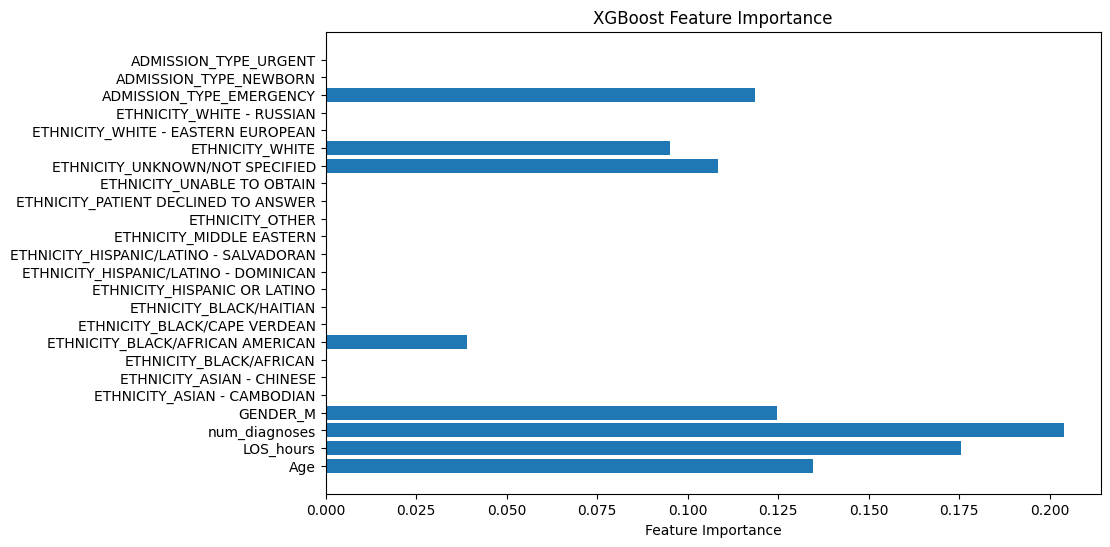

In [126]:
# Optional: Feature importance
import matplotlib.pyplot as plt

# Plot feature importance
xgb_importances = xgb_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, xgb_importances)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.show()


Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1716 - loss: 13.1845 - val_accuracy: 0.0957 - val_loss: 14.4160
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1589 - loss: 13.3683 - val_accuracy: 0.3298 - val_loss: 10.5526
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5941 - loss: 6.4716 - val_accuracy: 0.9149 - val_loss: 1.3718
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8601 - loss: 2.2548 - val_accuracy: 0.9149 - val_loss: 1.3718
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8910 - loss: 1.7566 - val_accuracy: 0.9149 - val_loss: 1.3718
Test Accuracy: 0.8983
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
ROC AUC: 0.5000

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95       106
           1       0.00      0.00      0.00        12

    accuracy                           0.90       118
   macro avg       0.45      0.50      0.47       1

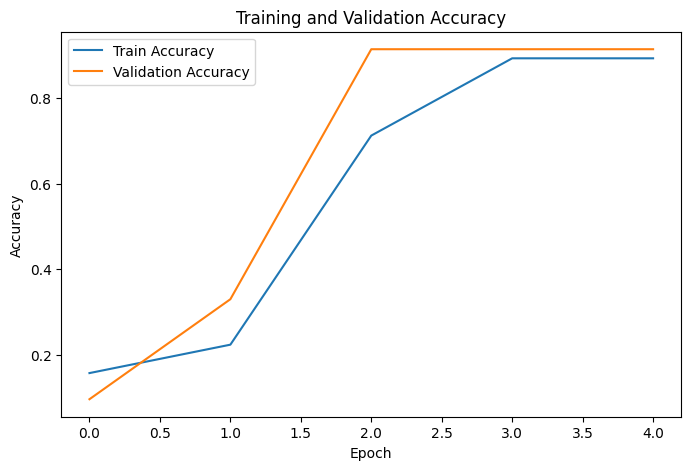

In [144]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

# Drop identifier columns
model_df = final_df.drop(columns=["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID"])

# One-hot encode categorical variables: GENDER, ETHNICITY, ADMISSION_TYPE
model_df = pd.get_dummies(model_df, columns=["GENDER", "ETHNICITY", "ADMISSION_TYPE"], drop_first=True)

# Define features (X) and target (y)
X = model_df.drop(columns=["mortality"])
y = model_df["mortality"]

# Fill missing values in features
X = X.fillna(0)

# Optionally, normalize features (uncomment if needed)
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split into training and testing sets (80-20 split; stratify to preserve target distribution)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Build the DNN Model ---
model = Sequential()
# Instead of using input_dim, use an Input layer for clarity
model.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='swish'))
model.add(Dense(1, activation='relu'))  # output layer for binary classification

# Compile the model with binary crossentropy loss and adam optimizer
model.compile(optimizer=optimizers.Adam(learning_rate=5e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model; validation_split reserves 20% of the training data for validation
history = model.fit(X_train, y_train, epochs=5, batch_size=12, validation_split=0.2, verbose=1)

# --- Evaluate the Model ---
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: {:.4f}".format(accuracy))

# Generate predicted probabilities and binary predictions
y_prob = model.predict(X_test).flatten()
y_pred = (y_prob > 0.5).astype(int)

print("ROC AUC: {:.4f}".format(roc_auc_score(y_test, y_prob)))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Plot Training History ---
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [128]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 1.0]
}

xgb_clf = XGBClassifier(eval_metric='logloss', random_state=42)
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid,
                           scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best ROC AUC:", grid_search.best_score_)

# Evaluate on test set
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)
y_prob = best_xgb.predict_proba(X_test)[:, 1]
print("Test ROC AUC: {:.4f}".format(roc_auc_score(y_test, y_prob)))


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best ROC AUC: 0.7961531155015198
Test ROC AUC: 0.8467


In [133]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='sigmoid'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='swish'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='swish')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: {:.4f}".format(accuracy))
y_prob = model.predict(X_test).flatten()
print("Test ROC AUC: {:.4f}".format(roc_auc_score(y_test, y_prob)))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.6838 - loss: 3.7649 - val_accuracy: 0.9149 - val_loss: 0.3206
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7097 - loss: 3.5692 - val_accuracy: 0.9149 - val_loss: 0.2654
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7447 - loss: 2.8460 - val_accuracy: 0.9149 - val_loss: 0.2363
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7408 - loss: 3.1245 - val_accuracy: 0.9149 - val_loss: 0.6687
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7862 - loss: 2.3304 - val_accuracy: 0.9149 - val_loss: 0.7932
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7667 - loss: 2.5318 - val_accuracy: 0.9149 - val_loss: 0.9235
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8242 - loss: 2.2214 - val_accuracy: 0.9149 - val_loss: 0.9221
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7932 - loss: 2.1835 - val_accuracy: 0.9149 - v

In [134]:
import os, warnings, logging, tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')  # pandas / sklearn etc.
logging.getLogger('xgboost').setLevel(logging.ERROR)


In [135]:
from sklearn.metrics import roc_auc_score, classification_report

# ----- For XGBoost Model -----
# Assuming xgb_model is your trained XGBoost model
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("----- XGBoost Model Evaluation -----")
print("XGBoost ROC AUC: {:.4f}".format(roc_auc_score(y_test, y_prob_xgb)))
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))


# ----- For DNN Model -----
# Assuming 'model' is your trained DNN model
y_prob_dnn = model.predict(X_test).flatten()
y_pred_dnn = (y_prob_dnn > 0.5).astype(int)

print("\n----- DNN Model Evaluation -----")
print("DNN ROC AUC: {:.4f}".format(roc_auc_score(y_test, y_prob_dnn)))
print("\nDNN Classification Report:\n", classification_report(y_test, y_pred_dnn))


----- XGBoost Model Evaluation -----
XGBoost ROC AUC: 0.9096

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96       106
           1       1.00      0.33      0.50        12

    accuracy                           0.93       118
   macro avg       0.96      0.67      0.73       118
weighted avg       0.94      0.93      0.92       118

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

----- DNN Model Evaluation -----
DNN ROC AUC: 0.7563

DNN Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95       106
           1       0.00      0.00      0.00        12

    accuracy                           0.90       118
   macro avg       0.45      0.50      0.47       118
weighted avg       0.81      0.90      0.85       118



In [136]:
# %%  --- Feature‑level importance for the DNN via Integrated Gradients ---

import tensorflow as tf
import numpy as np
import pandas as pd

# ------------------------------------------------------------------ #
# 1. Integrated‑Gradients helper (Keras‑friendly, 2‑D inputs)        #
# ------------------------------------------------------------------ #
def integrated_gradients(model, inputs, baseline=None, steps: int = 50):
    """
    Integrated Gradients for a batch of samples.
    --------------------------------------------
    • model   : tf.keras.Model returning a probability / logit
    • inputs  : tf.Tensor, shape (B, F)
    • baseline: tf.Tensor, shape (B, F) – default all‑zeros
    • steps   : number of interpolation points along the path
    Returns
    -------
    tf.Tensor, shape (B, F) – attribution per feature
    """
    if baseline is None:
        baseline = tf.zeros_like(inputs)

    # Linear interpolation between baseline and input
    alphas = tf.linspace(0.0, 1.0, steps + 1)           # (S+1,)
    alphas = tf.reshape(alphas, [-1, 1, 1])              # (S+1,1,1)
    delta  = tf.expand_dims(inputs - baseline, 0)        # (1,B,F)
    interpolated = baseline + alphas * delta             # (S+1,B,F)

    # Flatten so model sees 2‑D (samples, features)
    flat_interp = tf.reshape(interpolated,
                             [-1, inputs.shape[-1]])      # ((S+1)*B, F)

    with tf.GradientTape() as tape:
        tape.watch(flat_interp)
        preds = model(flat_interp, training=False)       # ((S+1)*B, 1)

    # Restore gradients to (S+1, B, F)
    grads = tape.gradient(preds, flat_interp)
    grads = tf.reshape(grads,
                       [steps + 1, -1, inputs.shape[-1]])  # (S+1,B,F)

    avg_grads = tf.reduce_mean(grads[:-1], axis=0)       # (B,F)
    return (inputs - baseline) * avg_grads               # (B,F)


# ------------------------------------------------------------------ #
# 2. Compute DNN attributions over the *test* split                  #
# ------------------------------------------------------------------ #
BATCH = 256
attr_sum = np.zeros(X_test.shape[1])

for start in range(0, len(X_test), BATCH):
    batch_np = X_test.iloc[start:start+BATCH].to_numpy(dtype='float32')
    xb = tf.convert_to_tensor(batch_np)
    ig_batch = integrated_gradients(model, xb, steps=50)
    attr_sum += np.abs(ig_batch.numpy()).sum(axis=0)     # sign‑agnostic

dnn_importance = attr_sum / attr_sum.sum()
feature_names  = X_test.columns


# ------------------------------------------------------------------ #
# 3. Pull XGBoost *gain* importance (keys are real column names)     #
# ------------------------------------------------------------------ #
booster   = xgb_model.get_booster()
raw_gain  = booster.get_score(importance_type='gain')    # dict {col: val}
xgb_gain  = pd.Series(raw_gain, index=feature_names).fillna(0)
xgb_gain /= xgb_gain.sum()


# ------------------------------------------------------------------ #
# 4. Build tidy comparison table                                     #
# ------------------------------------------------------------------ #
importance_df = (pd.DataFrame({
        'feature'                 : feature_names,
        'xgboost_gain'            : xgb_gain.values,
        'dnn_integrated_gradients': dnn_importance
    })
    .sort_values('dnn_integrated_gradients', ascending=False)
    .reset_index(drop=True)
)

display(importance_df.head(20))


,feature,xgboost_gain,dnn_integrated_gradients
0,LOS_hours,0.175407,0.565007
1,Age,0.134682,0.394063
2,num_diagnoses,0.203908,0.017854
3,ADMISSION_TYPE_EMERGENCY,0.118640,0.008437
4,ETHNICITY_WHITE,0.095089,0.007131
5,GENDER_M,0.124823,0.003468
6,ETHNICITY_UNKNOWN/NOT SPECIFIED,0.108455,0.001061
7,ADMISSION_TYPE_NEWBORN,0.000000,0.000968
8,ETHNICITY_HISPANIC OR LATINO,0.000000,0.000803
9,ETHNICITY_BLACK/AFRICAN AMERICAN,0.038997,0.000521
